In [1]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
sys.path.append(os.path.expanduser("~/Projects/inference_planning"))

In [2]:
import numpy as np
import tensorflow as tf
import gpflow as gf

from vgpmp.dynamics import ConstantVelocityModel
from vgpmp.prior import GaussMarkovPrior
from vgpmp.likelihood import CollisionLikelihood
from vgpmp.models import VGP

DTYPE = tf.float32
gf.config.set_default_float(DTYPE)

JITTER = tf.constant(1e-3, dtype=DTYPE)
gf.config.set_default_jitter(1e-6)

2025-11-30 17:45:26.722058: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-30 17:45:26.747724: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-30 17:45:26.747750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-30 17:45:26.748673: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-11-30 17:45:26.753371: I tensorflow/core/platform/cpu_feature_guar

In [3]:
"""Dynamics Model"""
# shape(times) = num of segments + 1
times = tf.constant(np.linspace(0.0, 1.0, 51), dtype=DTYPE)

dof = 2
dynamics_model = ConstantVelocityModel(dof, q_acc=1e-12)

In [4]:
"""Prior"""
# initial
K0  = tf.linalg.diag(
    tf.concat([
        1e-3*tf.ones([dof], DTYPE),     # q0 variance
        1e-3*tf.ones([dof], DTYPE),     # v0 variance
    ], axis=0)
)                                       # shape (D, D)
mu0 = tf.concat([
    tf.zeros([dof], DTYPE),
    tf.zeros([dof], DTYPE)
], axis=0)
start = (K0, mu0)

q_goal = tf.constant([10.0, 10.0], dtype=DTYPE)

# terminal
KN  = tf.linalg.diag(
    tf.concat([
        1e-3*tf.ones([dof], DTYPE),    # q0 variance
        1e-3*tf.ones([dof], DTYPE),    # v0 variance
    ], axis=0)
)
muN = tf.concat([
    q_goal,
    tf.zeros([dof], DTYPE)
], axis=0)
end = (KN, muN)

prior = GaussMarkovPrior(
    times,
    dynamics=dynamics_model,
    start=start,
    end=end,
    jitter=JITTER
)

In [5]:
# Build likelihood for a single circular obstacle centered at (5, 5) with radius 2.0
likelihood = CollisionLikelihood(
    N=prior.num_segments,
    D=prior.block_dim,
    obstacle_center=(5.0, 5.0),
    obstacle_radius=2.0,
    grid_size=10.0,
    epsilon=0.3,
    sigma_obs=0.05,
    sigma_box=0.05,
    lambda_collision=1.0,
    lambda_box=1.0,
    enforce_box=True,
)

In [6]:
model = VGP(prior, likelihood)

In [7]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-2)
_ = model.trainable_variables
opt.build(model.trainable_variables)

@tf.function(jit_compile=False)
def step(model, nsamples=32):
    with tf.GradientTape() as tape:
        loss = -model.elbo(nsamples=nsamples)
    grads = tape.gradient(loss, model.trainable_variables)
    # optional gradient clipping
    grads = [tf.clip_by_norm(g, 5.0) if g is not None else None for g in grads]
    opt.apply_gradients(zip(grads, model.trainable_variables))
    return loss

In [8]:
for it in range(100):
    loss_val = step(model, nsamples=32)
    if it % 10 == 0:
        tf.print("iter", it, "negELBO", loss_val)

iter 0 negELBO 412840.125
iter 10 negELBO 319094.406
iter 20 negELBO 253053.109
iter 30 negELBO 211375.516
iter 40 negELBO 185234.172
iter 50 negELBO 168876.234
iter 60 negELBO 157590.031
iter 70 negELBO 148928.594
iter 80 negELBO 141630.453
iter 90 negELBO 135054.031


In [ ]:
## Mean plan on the support grid
plan = model.m.numpy()  # shape: (N+1, D)

q_plan = plan[:, :dof]  # positions only
v_plan = plan[:, dof:]  # velocities

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_mean_and_obstacle(model):
    # Mean positions: first 2 dims of the mean vector
    q_mean = model.m.numpy()[:, :2]  # shape (N+1, 2)

    # Obstacle params
    cx, cy = model.likelihood.center.numpy()
    r = float(model.likelihood.radius.numpy())
    eps = float(model.likelihood.epsilon.numpy())
    L = float(model.likelihood.grid_size.numpy())

    fig, ax = plt.subplots()
    ax.plot(q_mean[:, 0], q_mean[:, 1], "-o", label="mean trajectory", color="C0")

    # Obstacle circle and (optional) safety buffer R+epsilon
    circle = plt.Circle((cx, cy), r, color="red", alpha=0.25, label="obstacle")
    buffer = plt.Circle((cx, cy), r + eps, color="red", alpha=0.1, fill=False, linestyle="--", label="radius + epsilon")
    ax.add_patch(circle)
    ax.add_patch(buffer)

    ax.set_xlim(0, L)
    ax.set_ylim(0, L)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.legend()
    ax.set_title("Mean trajectory and circular obstacle")
    plt.show()

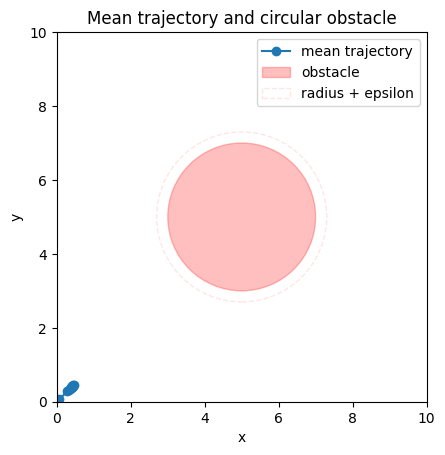

In [10]:
plot_mean_and_obstacle(model)